## This will set up data for Location Prediction within boroughs

### Links: 
- Project 2 pdf from Econ412
- Look up: "how to determine if linear or nonlinear is appropriate for model"
- https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1
- https://medium.datadriveninvestor.com/weighted-k-means-clustering-of-gps-coordinates-python-7c6270846163
- https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i
- https://patrickparrottalaw.com/differences-between-a-violation-a-misdemeanor-and-a-felony/
- https://stackoverflow.com/questions/41639557/how-to-perform-logistic-lasso-in-python
- https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/#:~:text=K%20means%20is%20one%20of,having%20similar%20features%2C%20common%20patterns.
- https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn
- https://machinelearningmastery.com/linear-discriminant-analysis-with-python/
- https://realpython.com/logistic-regression-python/
- https://www.statology.org/linear-discriminant-analysis-in-python/
- https://stackoverflow.com/questions/41639557/how-to-perform-logistic-lasso-in-python
- https://learn.g2.com/k-nearest-neighbor
- https://elitedatascience.com/bias-variance-tradeoff
- searh: "naive bayes classifier"

- Set up the data for classification beginning with Queens. Try to find difference between Crime start and crime end.
    - variables: crime rate? difference? UNRATE? Crime level? ARREST RATE? Premises? other dummies?
- Use K-means to create clusters using GPS coordinates for boroughs not already clustered
- Use other classification models:
    - LDA, QDA, KNN, Other?

In [102]:
import pandas as pd
import numpy as np
from math import radians
from sklearn. linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn. linear_model import LassoCV
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import statsmodels.api as sm
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.patches as mpatches

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data['PATROL_BORO'].unique()

array(['PATROL BORO QUEENS NORTH', 'PATROL BORO QUEENS SOUTH',
       'PATROL BORO MAN SOUTH', 'PATROL BORO MAN NORTH',
       'PATROL BORO BKLYN SOUTH', 'PATROL BORO BKLYN NORTH',
       'PATROL BORO BRONX', 'PATROL BORO STATEN ISLAND', nan],
      dtype=object)

In [122]:
len(data)

1792148

In [4]:
################################################################################################################################

# Integrate date difference to original dataset

In [4]:
index = list(range(1, 1792148+1))
data['index'] = index
crime_diff = pd.read_csv('crime_diff.csv')
crime_diff.head(3)

,index,crime_diff
0,1,596
1,2,364
2,3,1047


In [5]:
data = pd.merge(data, crime_diff,on='index', how = 'outer')
data.head(3)

,Unnamed: 0,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,year,date_y,borough_y,crimes,time_borough,location_yr,pop,crime_rate,index,crime_diff
0,0,216044876,2017-01-01,11:00:00,08/20/2018,109.0,12/31/2019,116,SEX CRIMES,179.0,...,2017,201701,queens,7617,201701queens,2017queens,2358582,322.95,1,596.0
1,1,669902330,2017-01-01,00:01:00,12/31/2017,114.0,11/26/2019,233,SEX CRIMES,175.0,...,2017,201701,queens,7617,201701queens,2017queens,2358582,322.95,2,364.0
2,2,336910010,2017-01-01,12:00:00,11/14/2019,104.0,11/14/2019,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,2017,201701,queens,7617,201701queens,2017queens,2358582,322.95,3,1047.0


In [6]:
################################################################################################################################

In [7]:
df = data[['borough_y', 'crime_rate', 'PATROL_BORO', 'crime_diff', 'Latitude', 'Longitude']]
df['borough'] = df['borough_y']
df = df.drop('borough_y', axis=1)
df.head()

<ipython-input-7-4887ffc6ec17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['borough'] = df['borough_y']


,crime_rate,PATROL_BORO,crime_diff,Latitude,Longitude,borough
0,322.95,PATROL BORO QUEENS NORTH,596.0,40.762334,-73.826917,queens
1,322.95,PATROL BORO QUEENS NORTH,364.0,40.769306,-73.915508,queens
2,322.95,PATROL BORO QUEENS NORTH,1047.0,40.717372,-73.900820,queens
3,322.95,PATROL BORO QUEENS SOUTH,364.0,40.679700,-73.776047,queens
4,322.95,PATROL BORO QUEENS NORTH,585.0,40.745253,-73.870063,queens


In [8]:
law_cat = pd.get_dummies(data["LAW_CAT_CD"])
#law_cat
## dummy variable for type of crime, reference is when it is a violation
df['felony'] = law_cat['FELONY']
df['misdemeanor'] = law_cat['MISDEMEANOR']
#df['violation'] = law_cat['VIOLATION']
### Dummy variable for whether crime was completed or not, attempted crimes are reference
completed_attempted = pd.get_dummies(data['CRM_ATPT_CPTD_CD'])
df['completed'] = completed_attempted['COMPLETED']
#completed_attempted
### Dummy variable for race of suspect, reference dummy is when it is unknown/NaN
data['SUSP_RACE'].value_counts()
suspect_race = pd.get_dummies(data['SUSP_RACE'], dummy_na=True)
df['s_native'] = suspect_race['AMERICAN INDIAN/ALASKAN NATIVE']
df['s_apac'] = suspect_race['ASIAN / PACIFIC ISLANDER']
df['s_black'] = suspect_race['BLACK']
df['s_bl_hisp'] = suspect_race['BLACK HISPANIC']
df['s_white'] = suspect_race['WHITE']
df['s_white_hisp'] = suspect_race['WHITE HISPANIC']
#suspect_race
#Dummy variable for suspect age, reference is unknown/NaN
data['SUSP_AGE_GROUP'].value_counts()
suspect_age = pd.get_dummies(data['SUSP_AGE_GROUP'], dummy_na=True)
suspect_age.head(3)
df['s_u18'] = suspect_age['<18']
df['s_18_24'] = suspect_age['18-24']
df['s_25_44'] = suspect_age['25-44']
df['s_45_64'] = suspect_age['45-64']
df['s_65plus'] = suspect_age['65+']
#dummy for suspect sex, reference is unknown
suspect_sex = pd.get_dummies(data['SUSP_SEX'], dummy_na=True)
suspect_sex.head(3)
df['s_male'] = suspect_sex['M']
df['s_female'] = suspect_sex['F']
#sex of victim, reference is other gender
victim_sex = pd.get_dummies(data['VIC_SEX'], dummy_na=True)
victim_sex.head(3)
df['v_male'] = victim_sex['M']
df['v_female'] = victim_sex['F']
##dummies for victim race, reference is unknown
victim_race = pd.get_dummies(data['VIC_RACE'], dummy_na=True)
df['v_native'] = victim_race['AMERICAN INDIAN/ALASKAN NATIVE']
df['v_apac'] = victim_race['ASIAN / PACIFIC ISLANDER']
df['v_black'] = victim_race['BLACK']
df['v_bl_hisp'] = victim_race['BLACK HISPANIC']
df['v_white'] = victim_race['WHITE']
df['v_white_hisp'] = victim_race['WHITE HISPANIC']
##dummies for victim age group, reference is unknown/other
data['VIC_AGE_GROUP'].value_counts()
victim_age = pd.get_dummies(data['VIC_AGE_GROUP'], dummy_na=True)
victim_age.head(3)
df['v_u18'] = victim_age['<18']
df['v_18_24'] = victim_age['18-24']
df['v_25_44'] = victim_age['25-44']
df['v_45_64'] = victim_age['45-64']
df['v_65plus'] = victim_age['65+']


In [9]:
df.head(3)

,crime_rate,PATROL_BORO,crime_diff,Latitude,Longitude,borough,felony,misdemeanor,completed,s_native,...,v_apac,v_black,v_bl_hisp,v_white,v_white_hisp,v_u18,v_18_24,v_25_44,v_45_64,v_65plus
0,322.95,PATROL BORO QUEENS NORTH,596.0,40.762334,-73.826917,queens,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
1,322.95,PATROL BORO QUEENS NORTH,364.0,40.769306,-73.915508,queens,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
2,322.95,PATROL BORO QUEENS NORTH,1047.0,40.717372,-73.900820,queens,0,1,1,0,...,0,0,0,1,0,0,1,0,0,0


In [10]:
data['CMPLNT_FR_DT'] = data['CMPLNT_FR_DT'].astype(str)
data['CMPLNT_FR_DT'] = pd.to_datetime(data['CMPLNT_FR_DT'].astype(str), format='%Y-%m-%d')
#data['month'] = pd.to_datetime(data['CMPLNT_FR_DT'],format='%m', errors='coerce').dt.to_period('m')
data['month'] = pd.DatetimeIndex(data['CMPLNT_FR_DT']).month
##dummies depending on month of year, reference is january
month = pd.get_dummies(data['month'], dummy_na=True)
month.head()
df['feb'] = month[2.0]
df['mar'] = month[3.0]
df['apr'] = month[4.0]
df['may'] = month[5.0]
df['jun'] = month[6.0]
df['jul'] = month[7.0]
df['aug'] = month[8.0]
df['sep'] = month[9.0]
df['oct'] = month[10.0]
df['nov'] = month[11.0]
df['dec'] = month[12.0]

In [11]:
### Dummy variable for description of premises of crime, street is the reference dummy
premises = pd.get_dummies(data['PREM_TYP_DESC'])
premises.head(3)
premises = premises.drop('STREET', axis=1)
##creates index to merge dataframes and sets disorderly conduct as reference dummy
df['index'] = index
premises['index'] = index
df.head(3)

,crime_rate,PATROL_BORO,crime_diff,Latitude,Longitude,borough,felony,misdemeanor,completed,s_native,...,apr,may,jun,jul,aug,sep,oct,nov,dec,index
0,322.95,PATROL BORO QUEENS NORTH,596.0,40.762334,-73.826917,queens,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,322.95,PATROL BORO QUEENS NORTH,364.0,40.769306,-73.915508,queens,0,1,1,0,...,0,0,0,0,0,0,0,0,0,2
2,322.95,PATROL BORO QUEENS NORTH,1047.0,40.717372,-73.900820,queens,0,1,1,0,...,0,0,0,0,0,0,0,0,0,3


In [12]:
len(data['PREM_TYP_DESC'].unique())

75

In [13]:
df = pd.merge(left=df, right=premises, left_on='index', right_on='index')
df = df.drop(['index'], axis=1)
#df.head(3)

In [14]:
econ = pd.read_csv('economic_indicators.csv')
econ = econ.drop('Unnamed: 0', axis=1)
#econ.head(3)
df = pd.merge(left=df, right=econ, left_on='borough', right_on='borough')
#df.head(3)
#df = df.drop('borough', axis=1)
df = df.drop('foreign_percent', axis=1)
df.head(3)


,crime_rate,PATROL_BORO,crime_diff,Latitude,Longitude,borough,felony,misdemeanor,completed,s_native,...,VARIETY STORE,VIDEO STORE,median_age,poverty_rate,unemployment_rate,educ,labor_part,hispanic_rate,black_rate,asian_rate
0,322.95,PATROL BORO QUEENS NORTH,596.0,40.762334,-73.826917,queens,1,0,1,0,...,0,0,39.0,12.2,5.6,32.2,64.2,27.76,15.85,27.3
1,322.95,PATROL BORO QUEENS NORTH,364.0,40.769306,-73.915508,queens,0,1,1,0,...,0,0,39.0,12.2,5.6,32.2,64.2,27.76,15.85,27.3
2,322.95,PATROL BORO QUEENS NORTH,1047.0,40.717372,-73.900820,queens,0,1,1,0,...,0,0,39.0,12.2,5.6,32.2,64.2,27.76,15.85,27.3


In [15]:
len(df)

1790832

In [16]:
pre_scale = df[['crime_rate','crime_diff','median_age','poverty_rate', 'unemployment_rate',  'educ', 'hispanic_rate', 'black_rate', 'asian_rate', 'labor_part']]
df = df.drop(['crime_rate','crime_diff','median_age','poverty_rate', 'unemployment_rate',  'educ', 'hispanic_rate', 'black_rate', 'asian_rate', 'labor_part'],axis=1)
pre_scale.head()

,crime_rate,crime_diff,median_age,poverty_rate,unemployment_rate,educ,hispanic_rate,black_rate,asian_rate,labor_part
0,322.95,596.0,39.0,12.2,5.6,32.2,27.76,15.85,27.3,64.2
1,322.95,364.0,39.0,12.2,5.6,32.2,27.76,15.85,27.3,64.2
2,322.95,1047.0,39.0,12.2,5.6,32.2,27.76,15.85,27.3,64.2
3,322.95,364.0,39.0,12.2,5.6,32.2,27.76,15.85,27.3,64.2
4,322.95,585.0,39.0,12.2,5.6,32.2,27.76,15.85,27.3,64.2


In [17]:
scaler = preprocessing.StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(pre_scale))
scaled.head()

,0,1,2,3,4,5,6,7,8,9
0,-1.278982,22.413513,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365
1,-1.278982,13.645411,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365
2,-1.278982,39.458402,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365
3,-1.278982,13.645411,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365
4,-1.278982,21.997784,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365


In [16]:
scaled = scaled.rename(columns={0:'crime_rate',1:'crime_diff',2: "median_age", 3: "poverty_rate", 4: "unemployment_rate",5: "educ",
                       6: "hispanic_rate",7: "black_rate",8: "asian_rate", 9:"labor_part"})

In [18]:
len(df)

1790832

In [19]:
len(scaled)
index = list(range(1, 1790832+1))
df['index'] = index
scaled['index'] = index

In [20]:
df = pd.merge(left=df, right=scaled, left_on='index', right_on='index')
df = df.drop('index', axis=1)
df.head()

,PATROL_BORO,Latitude,Longitude,borough,felony,misdemeanor,completed,s_native,s_apac,s_black,...,0,1,2,3,4,5,6,7,8,9
0,PATROL BORO QUEENS NORTH,40.762334,-73.826917,queens,1,0,1,0,1,0,...,-1.278982,22.413513,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365
1,PATROL BORO QUEENS NORTH,40.769306,-73.915508,queens,0,1,1,0,0,1,...,-1.278982,13.645411,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365
2,PATROL BORO QUEENS NORTH,40.717372,-73.900820,queens,0,1,1,0,0,0,...,-1.278982,39.458402,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365
3,PATROL BORO QUEENS SOUTH,40.679700,-73.776047,queens,1,0,1,0,0,0,...,-1.278982,13.645411,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365
4,PATROL BORO QUEENS NORTH,40.745253,-73.870063,queens,0,1,1,0,0,1,...,-1.278982,21.997784,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365


In [ ]:
################################################################################################################################

In [23]:
queens = df[df['borough']=='queens']
queens = queens.drop(['borough','Latitude','Longitude'], axis=1)
#queens.head()
queens['PATROL_BORO'].value_counts()

PATROL BORO QUEENS NORTH    187377
PATROL BORO QUEENS SOUTH    173091
Name: PATROL_BORO, dtype: int64

In [19]:
len(queens)

360468

In [20]:
queens['index'] = index[:360468]
queens.head(1)

,PATROL_BORO,felony,misdemeanor,completed,s_native,s_apac,s_black,s_bl_hisp,s_white,s_white_hisp,...,crime_diff,median_age,poverty_rate,unemployment_rate,educ,hispanic_rate,black_rate,asian_rate,labor_part,index
0,PATROL BORO QUEENS NORTH,1,0,1,0,1,0,0,0,0,...,22.413513,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365,1


In [21]:
queens_d = pd.get_dummies(queens['PATROL_BORO'])
queens_d = queens_d.drop('PATROL BORO QUEENS SOUTH', axis=1) #####NORTH WILL BE REFERENCE FOR LOGISTIC
queens_d['index'] = index[:360468]
queens = pd.merge(left=queens, right=queens_d, left_on='index', right_on='index')
queens = queens.drop(['PATROL_BORO', 'index'], axis=1)
queens.head()

,felony,misdemeanor,completed,s_native,s_apac,s_black,s_bl_hisp,s_white,s_white_hisp,s_u18,...,crime_diff,median_age,poverty_rate,unemployment_rate,educ,hispanic_rate,black_rate,asian_rate,labor_part,PATROL BORO QUEENS NORTH
0,1,0,1,0,1,0,0,0,0,0,...,22.413513,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365,1
1,0,1,1,0,0,1,0,0,0,0,...,13.645411,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365,1
2,0,1,1,0,0,0,0,0,0,0,...,39.458402,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365,1
3,1,0,1,0,0,0,0,0,0,0,...,13.645411,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365,0
4,0,1,1,0,0,1,0,0,0,1,...,21.997784,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365,1


In [ ]:
################################################################################################################################

In [22]:
queens = queens.dropna()


In [ ]:
################################################################################################################################

In [23]:
y = np.array(queens['PATROL BORO QUEENS NORTH'])
queens = queens.drop('PATROL BORO QUEENS NORTH', axis=1)
queens.head(3)
Xtilde = np.array(queens)
#Xtilde[0]

In [24]:
queens.head(3)

,felony,misdemeanor,completed,s_native,s_apac,s_black,s_bl_hisp,s_white,s_white_hisp,s_u18,...,crime_rate,crime_diff,median_age,poverty_rate,unemployment_rate,educ,hispanic_rate,black_rate,asian_rate,labor_part
0,1,0,1,0,1,0,0,0,0,0,...,-1.278982,22.413513,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365
1,0,1,1,0,0,1,0,0,0,0,...,-1.278982,13.645411,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365
2,0,1,1,0,0,0,0,0,0,0,...,-1.278982,39.458402,1.252528,-1.054108,-0.538622,-0.434118,-0.146719,-0.636541,1.767097,0.23365


# Queens Analysis
## Logistic regression with L1 ("LASSO") Penalty

### Test different C's for regularization strength

In [109]:
(Xt ,Xv ,Yt ,Yv)= train_test_split (Xtilde ,y, test_size =0.3 , random_state =0, shuffle = True)

In [110]:
log = LogisticRegression(penalty='l1', solver='liblinear', C=10.0)
log.fit(Xt, Yt)

LogisticRegression(C=10.0, penalty='l1', solver='liblinear')

In [111]:
log.intercept_

array([0.03447771])

In [112]:
len(log.coef_[0])

123

In [113]:
logit_coefs = pd.DataFrame(queens.columns)
logit_coefs['coefs'] = log.coef_[0]
logit_coefs['column_names'] = logit_coefs[0]
logit_coefs['abs_coefs'] = abs(logit_coefs['coefs'])
logit_coefs = logit_coefs.drop(0, axis=1)

In [114]:
logit_coefs.head(1)

,coefs,column_names,abs_coefs
0,-0.152236,felony,0.152236


In [115]:
###take absolute value of coefs
sorted_coefs = logit_coefs.sort_values(by=['abs_coefs'], ascending=False)
#sorted_coefs = sorted_coefs.reset_index()
list(sorted_coefs['column_names'])

['TRAMWAY',
 'DEPARTMENT STORE',
 'HOMELESS SHELTER',
 'SYNAGOGUE',
 'MARINA/PIER',
 'SHOE',
 'VIDEO STORE',
 'v_black',
 'TAXI (YELLOW LICENSED)',
 'BRIDGE',
 'RESIDENCE - PUBLIC HOUSING',
 's_black',
 'CEMETERY',
 'v_white',
 'FACTORY/WAREHOUSE',
 'v_white_hisp',
 'RESIDENCE-HOUSE',
 'SMALL MERCHANT',
 'STORE UNCLASSIFIED',
 'SOCIAL CLUB/POLICY',
 'BAR/NIGHT CLUB',
 'PHOTO/COPY',
 'AIRPORT TERMINAL',
 'RESTAURANT/DINER',
 'CLOTHING/BOUTIQUE',
 'v_female',
 'DRUG STORE',
 'CHAIN STORE',
 'hispanic_rate',
 'JEWELRY',
 'MOSQUE',
 'HOTEL/MOTEL',
 'CONSTRUCTION SITE',
 'HOSPITAL',
 'PUBLIC BUILDING',
 'BANK',
 'GYM/FITNESS FACILITY',
 'v_male',
 'OTHER',
 'OTHER HOUSE OF WORSHIP',
 'STORAGE FACILITY',
 'COMMERCIAL BUILDING',
 'BOOK/CARD',
 'BUS TERMINAL',
 'TAXI (LIVERY LICENSED)',
 'TELECOMM. STORE',
 'v_65plus',
 'PRIVATE/PAROCHIAL SCHOOL',
 'v_25_44',
 's_white_hisp',
 'HIGHWAY/PARKWAY',
 'TAXI/LIVERY (UNLICENSED)',
 'TRANSIT - NYC SUBWAY',
 's_native',
 'VARIETY STORE',
 'v_apac',
 'P

In [116]:
Y_pred = log.predict(Xv)

In [117]:
log.score(Xv,Yv)

0.7020556495686188

In [118]:
logit_conf_matrix = confusion_matrix(Yv, log.predict(Xv))
logit_conf_matrix

array([[31316, 20538],
       [11682, 44605]], dtype=int64)

In [119]:
print(classification_report(Yv, Y_pred))

              precision    recall  f1-score   support

           0       0.73      0.60      0.66     51854
           1       0.68      0.79      0.73     56287

    accuracy                           0.70    108141
   macro avg       0.71      0.70      0.70    108141
weighted avg       0.71      0.70      0.70    108141



## KNN model for Queens

In [82]:
q_n = int(((len(queens))**.5)-1)
q_n

599

In [89]:
knn = KNeighborsClassifier(n_neighbors=q_n)

In [90]:
knn.fit(Xt, Yt)

#Predict the response for test dataset
Ypr_knn = knn.predict(Xv)

In [91]:
print("Accuracy:",metrics.accuracy_score(Yv, Ypr_knn))

Accuracy: 0.6999565382232456


In [92]:
confusion_matrix(Yv, Ypr_knn)

array([[30779, 21075],
       [11372, 44915]], dtype=int64)

In [93]:
print(classification_report(Yv, Ypr_knn))

              precision    recall  f1-score   support

           0       0.73      0.59      0.65     51854
           1       0.68      0.80      0.73     56287

    accuracy                           0.70    108141
   macro avg       0.71      0.70      0.69    108141
weighted avg       0.70      0.70      0.70    108141



## Linear Discriminant Analysis for Queens

In [106]:
lda_q = LinearDiscriminantAnalysis()
lda_q.fit(Xt, Yt)

LinearDiscriminantAnalysis()

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = cross_val_score(lda_q, Xtilde, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores)) 

## Staten Island
## K-means to create clusters

In [20]:
staten = df[df['borough']=='staten']
staten.head(3)

,PATROL_BORO,Latitude,Longitude,borough,felony,misdemeanor,completed,s_native,s_apac,s_black,...,crime_rate,crime_diff,median_age,poverty_rate,unemployment_rate,educ,hispanic_rate,black_rate,asian_rate,labor_part
1713358,PATROL BORO STATEN ISLAND,40.644726,-74.077483,staten,1,0,1,0,0,1,...,-0.831872,37.379757,1.841786,-1.143037,-1.078113,-0.156535,-0.748478,-1.513101,-0.307033,-1.642121
1713359,PATROL BORO STATEN ISLAND,40.631382,-74.126220,staten,1,0,1,0,1,0,...,-0.831872,32.088661,1.841786,-1.143037,-1.078113,-0.156535,-0.748478,-1.513101,-0.307033,-1.642121
1713360,PATROL BORO STATEN ISLAND,40.644726,-74.077483,staten,0,1,1,0,0,0,...,-0.831872,27.440055,1.841786,-1.143037,-1.078113,-0.156535,-0.748478,-1.513101,-0.307033,-1.642121


In [21]:
len(staten)

77474

In [22]:
index_staten = list(range(1, len(staten)+1))
staten['index'] = index_staten
staten.head(1)

<ipython-input-22-6b9f4448599b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  staten['index'] = index_staten


,PATROL_BORO,Latitude,Longitude,borough,felony,misdemeanor,completed,s_native,s_apac,s_black,...,crime_diff,median_age,poverty_rate,unemployment_rate,educ,hispanic_rate,black_rate,asian_rate,labor_part,index
1713358,PATROL BORO STATEN ISLAND,40.644726,-74.077483,staten,1,0,1,0,0,1,...,37.379757,1.841786,-1.143037,-1.078113,-0.156535,-0.748478,-1.513101,-0.307033,-1.642121,1


In [23]:
st_cluster = staten[['Longitude', 'Latitude']]
st_cluster.head()

,Longitude,Latitude
1713358,-74.077483,40.644726
1713359,-74.126220,40.631382
1713360,-74.077483,40.644726
1713361,-74.177036,40.610567
1713362,-74.119802,40.632325


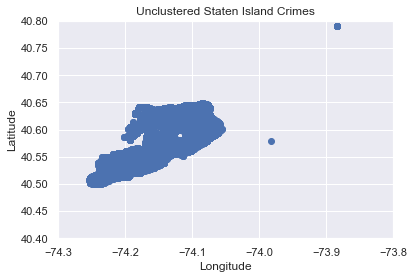

In [24]:
plt.scatter(st_cluster['Longitude'],st_cluster['Latitude'])
plt.xlim(-74.3,-73.8)
plt.ylim(40.4,40.8)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Unclustered Staten Island Crimes')
plt.show()

In [35]:
x = st_cluster.iloc[:,0:3] # 1t for rows and second for columns

In [55]:
kmeans = KMeans(2)
kmeans.fit(x)

KMeans(n_clusters=2)

In [56]:
identified_clusters = kmeans.fit_predict(x)
identified_clusters

array([1, 1, 1, ..., 1, 1, 1])

In [57]:
len(identified_clusters)

77474

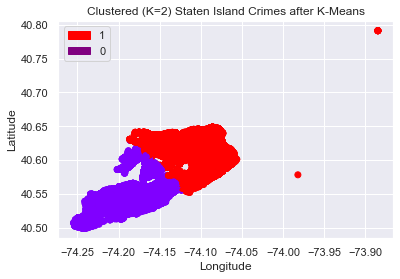

In [58]:
data_with_clusters = st_cluster.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['Longitude'],data_with_clusters['Latitude'],c=data_with_clusters['Clusters'],cmap='rainbow')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Clustered (K=2) Staten Island Crimes after K-Means')
red_patch = mpatches.Patch(color='red', label='1')
purple_patch = mpatches.Patch(color='purple', label='0')
plt.legend(handles=[red_patch, purple_patch])

plt.show()

In [59]:
data_with_clusters.head(3)

,Longitude,Latitude,Clusters
1713358,-74.077483,40.644726,1
1713359,-74.126220,40.631382,1
1713360,-74.077483,40.644726,1


In [60]:
staten['clusters'] = identified_clusters
staten.head(3)

,felony,misdemeanor,completed,s_native,s_apac,s_black,s_bl_hisp,s_white,s_white_hisp,s_u18,...,crime_diff,median_age,poverty_rate,unemployment_rate,educ,hispanic_rate,black_rate,asian_rate,labor_part,clusters
1713358,1,0,1,0,0,1,0,0,0,0,...,37.379757,1.841786,-1.143037,-1.078113,-0.156535,-0.748478,-1.513101,-0.307033,-1.642121,1
1713359,1,0,1,0,1,0,0,0,0,0,...,32.088661,1.841786,-1.143037,-1.078113,-0.156535,-0.748478,-1.513101,-0.307033,-1.642121,1
1713360,0,1,1,0,0,0,0,0,0,0,...,27.440055,1.841786,-1.143037,-1.078113,-0.156535,-0.748478,-1.513101,-0.307033,-1.642121,1


In [61]:
staten['clusters'].value_counts() ##1 is northeast,east; 0 is others

1    58611
0    18863
Name: clusters, dtype: int64

In [65]:
staten = staten.drop(['PATROL_BORO', 'Longitude', 'Latitude','index','borough'], axis=1)

In [48]:
staten = staten.dropna()
len(staten)

77474

In [49]:
staten.head(1)

,felony,misdemeanor,completed,s_native,s_apac,s_black,s_bl_hisp,s_white,s_white_hisp,s_u18,...,crime_diff,median_age,poverty_rate,unemployment_rate,educ,hispanic_rate,black_rate,asian_rate,labor_part,clusters
1713358,1,0,1,0,0,1,0,0,0,0,...,37.379757,1.841786,-1.143037,-1.078113,-0.156535,-0.748478,-1.513101,-0.307033,-1.642121,0


## Logistic regression for Staten Island w/ clusters from K-means starting w/ 2 clusters

In [66]:
y_st = np.array(staten['clusters'])
Xtil_st = np.array(staten.iloc[:,0:123])
#Xtil_st[0]

In [67]:
(Xt_st ,Xv_st ,Yt_st ,Yv_st)= train_test_split (Xtil_st ,y_st, test_size =0.3 , random_state =0, shuffle = True)

In [76]:
log_st = LogisticRegression(penalty='l1', solver='liblinear', C=10.0)
log_st.fit(Xt_st, Yt_st)
Ypred_st = log_st.predict(Xv_st)
log_st.score(Xv_st,Yv_st)

0.7624661188314762

In [77]:
logit_conf_matrix_st = confusion_matrix(Yv_st, log_st.predict(Xv_st))
logit_conf_matrix_st

array([[ 1317,  4304],
       [ 1217, 16405]], dtype=int64)

In [86]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores_log_st = cross_val_score(log_st, Xtil_st, y_st, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(scores_log_st)

0.7630688874918518

In [78]:
print(classification_report(Yv_st, Ypred_st))

              precision    recall  f1-score   support

           0       0.52      0.23      0.32      5621
           1       0.79      0.93      0.86     17622

    accuracy                           0.76     23243
   macro avg       0.66      0.58      0.59     23243
weighted avg       0.73      0.76      0.73     23243



## Knn for Staten Island w/ 2 categories

In [79]:
st_n = int(((len(staten))**.5)-1)
st_n

277

In [80]:
knn_st = KNeighborsClassifier(n_neighbors=st_n)
knn_st.fit(Xt_st, Yt_st)

#Predict the response for test dataset
Ypr_knn_st = knn_st.predict(Xv_st)
print("Accuracy:",metrics.accuracy_score(Yv_st, Ypr_knn_st))

Accuracy: 0.7598846964677537


In [82]:
scores_knn_st = cross_val_score(knn_st, Xtil_st, y_st, scoring='accuracy', cv=cv, n_jobs=-1)

In [85]:
np.mean(scores_knn_st)

0.759755986168765

In [85]:
print(confusion_matrix(Yv_st, Ypr_knn_st))
print(classification_report(Yv_st, Ypr_knn_st))

[[  370  5242]
 [  329 17302]]
              precision    recall  f1-score   support

           0       0.53      0.07      0.12      5612
           1       0.77      0.98      0.86     17631

    accuracy                           0.76     23243
   macro avg       0.65      0.52      0.49     23243
weighted avg       0.71      0.76      0.68     23243



## LDA for Staten w/ two clusters

In [87]:
lda_st = LinearDiscriminantAnalysis()
lda_st.fit(Xt_st, Yt_st)

LinearDiscriminantAnalysis()

In [88]:
Ypr_lda_st = lda_st.predict(Xv_st)
print("Accuracy:",metrics.accuracy_score(Yv_st, Ypr_lda_st))
print(confusion_matrix(Yv_st, Ypr_lda_st))
print(classification_report(Yv_st, Ypr_lda_st))

Accuracy: 0.7604870283526223
[[  111  5510]
 [   57 17565]]
              precision    recall  f1-score   support

           0       0.66      0.02      0.04      5621
           1       0.76      1.00      0.86     17622

    accuracy                           0.76     23243
   macro avg       0.71      0.51      0.45     23243
weighted avg       0.74      0.76      0.66     23243



In [89]:

#evaluate model
scores_lda_st = cross_val_score(lda_st, Xtil_st, y_st, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_lda_st))

0.7587835919760978


# Bronx models

In [46]:
bronx = df[df['borough']=='bronx']
bronx = bronx.dropna()
#bronx.head(3)
len(bronx)
index_bronx = list(range(1, len(bronx)+1))
bronx['index'] = index_bronx
#bronx.head(1)

In [48]:
br_cluster = bronx[['Longitude', 'Latitude']]
br_cluster.head(3)

,Longitude,Latitude
1320660,-73.888019,40.813056
1320661,-73.847608,40.887451
1320662,-73.847608,40.887451


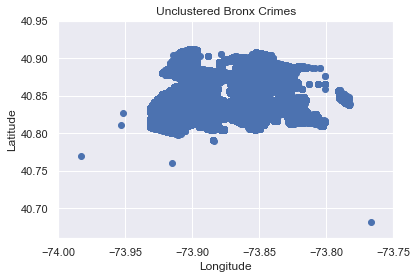

In [49]:
plt.scatter(br_cluster['Longitude'],br_cluster['Latitude'])
plt.xlim(-74.0,-73.75)
plt.ylim(40.66,40.95)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Unclustered Bronx Crimes')
plt.show()

In [50]:
br_cluster = br_cluster.dropna()
br_cluster.isna().sum()

Longitude    0
Latitude     0
dtype: int64

In [51]:
x = br_cluster.iloc[:,0:3] # 1t for rows and second for columns
kmeans = KMeans(2)
kmeans.fit(x)
identified_clusters = kmeans.fit_predict(x)
identified_clusters

array([0, 1, 1, ..., 0, 0, 0])

In [52]:
bronx_with_clusters.head(3)

,Longitude,Latitude,Clusters
1320660,-73.888019,40.813056,0
1320661,-73.847608,40.887451,1
1320662,-73.847608,40.887451,1


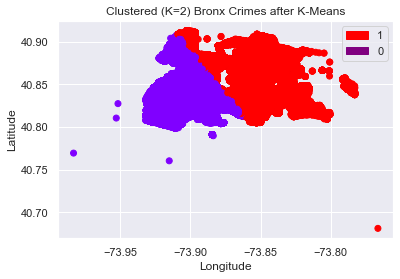

In [53]:
bronx_with_clusters = br_cluster.copy()
bronx_with_clusters['Clusters'] = identified_clusters 
plt.scatter(bronx_with_clusters['Longitude'],bronx_with_clusters['Latitude'],c=bronx_with_clusters['Clusters'],cmap='rainbow')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Clustered (K=2) Bronx Crimes after K-Means')
red_patch = mpatches.Patch(color='red', label='1')
purple_patch = mpatches.Patch(color='purple', label='0')
plt.legend(handles=[red_patch, purple_patch])

plt.show()

In [54]:
bronx['clusters'] = identified_clusters
bronx.head(3)

,PATROL_BORO,Latitude,Longitude,borough,felony,misdemeanor,completed,s_native,s_apac,s_black,...,2,3,4,5,6,7,8,9,index,clusters
1320660,PATROL BORO BRONX,40.813056,-73.888019,bronx,1,0,1,0,0,0,...,-1.318781,1.756053,1.835138,-1.252986,1.834682,1.093295,-1.280331,-1.433702,1,0
1320661,PATROL BORO BRONX,40.887451,-73.847608,bronx,0,1,1,0,0,1,...,-1.318781,1.756053,1.835138,-1.252986,1.834682,1.093295,-1.280331,-1.433702,2,1
1320662,PATROL BORO BRONX,40.887451,-73.847608,bronx,0,1,1,0,0,0,...,-1.318781,1.756053,1.835138,-1.252986,1.834682,1.093295,-1.280331,-1.433702,3,1


In [55]:
bronx = bronx.drop(['PATROL_BORO', 'Longitude', 'Latitude','index','borough'], axis=1)
bronx = bronx.dropna()
len(bronx)
bronx['clusters'].value_counts() ##0 is west; 1 is east

0    260843
1    131790
Name: clusters, dtype: int64

### Logistic Regression

In [117]:
len(bronx)

392633

In [58]:
y_br = np.array(bronx['clusters'])
Xtil_br = np.array(bronx.iloc[:,0:123])
#Xtil_st[0]
(Xt_br ,Xv_br ,Yt_br ,Yv_br)= train_test_split (Xtil_br ,y_br, test_size =0.3 , random_state =0, shuffle = True)
log_br = LogisticRegression(penalty='l1', solver='liblinear', C=10.0)
log_br.fit(Xt_br, Yt_br)
Ypred_br = log_br.predict(Xv_br)
log_br.score(Xv_br,Yv_br)

0.6914678665421513

In [59]:
logit_conf_matrix_br = confusion_matrix(Yv_br, log_br.predict(Xv_br))
logit_conf_matrix_br

array([[74671,  3653],
       [32689,  6777]], dtype=int64)

In [61]:
print(classification_report(Yv_br, Ypred_br))
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores_log_br = cross_val_score(log_br, Xtil_br, y_br, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_log_br))

              precision    recall  f1-score   support

           0       0.70      0.95      0.80     78324
           1       0.65      0.17      0.27     39466

    accuracy                           0.69    117790
   macro avg       0.67      0.56      0.54    117790
weighted avg       0.68      0.69      0.63    117790

0.6917494612019764


### kNN

In [62]:
br_n = int(((len(bronx))**.5)-1)
print('K: ', br_n)
knn_br = KNeighborsClassifier(n_neighbors=br_n)
knn_br.fit(Xt_br, Yt_br)

#Predict the response for test dataset
Ypr_knn_br = knn_br.predict(Xv_br)
print("Accuracy:",metrics.accuracy_score(Yv_br, Ypr_knn_br))
print(confusion_matrix(Yv_br, Ypr_knn_br))
print(classification_report(Yv_br, Ypr_knn_br))

K:  625
Accuracy: 0.6760675778928602
[[77879   445]
 [37711  1755]]
              precision    recall  f1-score   support

           0       0.67      0.99      0.80     78324
           1       0.80      0.04      0.08     39466

    accuracy                           0.68    117790
   macro avg       0.74      0.52      0.44    117790
weighted avg       0.72      0.68      0.56    117790



In [118]:
##RUN LATER
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores_knn_br = cross_val_score(knn_br, Xtil_br, y_br, scoring='accuracy', cv=cv, n_jobs=-1)
print('CV accuracy: ', np.mean(scores_knn_br))

CV accuracy:  0.6763007681108582


### LDA Model

In [63]:
lda_br = LinearDiscriminantAnalysis()
lda_br.fit(Xt_br, Yt_br)

Ypr_lda_br = lda_br.predict(Xv_br)
print("Accuracy:",metrics.accuracy_score(Yv_br, Ypr_lda_br))
print(confusion_matrix(Yv_br, Ypr_lda_br))
print(classification_report(Yv_br, Ypr_lda_br))
#evaluate model
scores_lda_br = cross_val_score(lda_br, Xtil_br, y_br, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_lda_br))

Accuracy: 0.6870022922149588
[[76860  1464]
 [35404  4062]]
              precision    recall  f1-score   support

           0       0.68      0.98      0.81     78324
           1       0.74      0.10      0.18     39466

    accuracy                           0.69    117790
   macro avg       0.71      0.54      0.49    117790
weighted avg       0.70      0.69      0.60    117790

0.6864697228582044


# Manhattan Models

In [64]:
manhattan = df[df['borough']=='manhattan']
manhattan = manhattan.dropna()
#bronx.head(3)
len(manhattan)
index_manhattan = list(range(1, len(manhattan)+1))
manhattan['index'] = index_manhattan
#bronx.head(1)
man_cluster = manhattan[['Longitude', 'Latitude']]
man_cluster.head(3)

,Longitude,Latitude
360468,-73.983316,40.736698
360469,-73.956682,40.814850
360470,-73.948516,40.816041


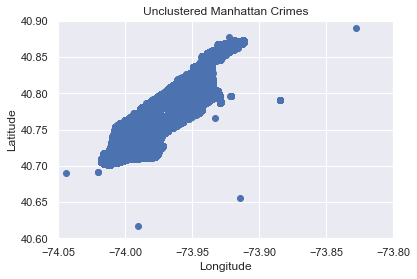

In [67]:
plt.scatter(man_cluster['Longitude'],man_cluster['Latitude'])
plt.xlim(-74.05,-73.80)
plt.ylim(40.60,40.90)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Unclustered Manhattan Crimes')
plt.show()

In [68]:
man_cluster = man_cluster.dropna()
man_cluster.isna().sum()
x = man_cluster.iloc[:,0:3] # 1t for rows and second for columns
kmeans = KMeans(2)
kmeans.fit(x)
identified_clusters_man = kmeans.fit_predict(x)
identified_clusters_man

array([0, 1, 1, ..., 0, 0, 0])

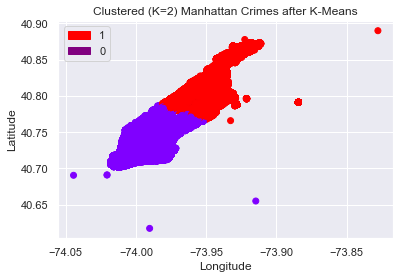

In [71]:
manhattan_with_clusters = man_cluster.copy()
manhattan_with_clusters['Clusters'] = identified_clusters_man 
plt.scatter(manhattan_with_clusters['Longitude'],manhattan_with_clusters['Latitude'],c=manhattan_with_clusters['Clusters'],cmap='rainbow')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Clustered (K=2) Manhattan Crimes after K-Means')
red_patch = mpatches.Patch(color='red', label='1')
purple_patch = mpatches.Patch(color='purple', label='0')
plt.legend(handles=[red_patch, purple_patch])

plt.show()

In [70]:
manhattan_with_clusters.head(3)

,Longitude,Latitude,Clusters
360468,-73.983316,40.736698,0
360469,-73.956682,40.814850,1
360470,-73.948516,40.816041,1


In [72]:
manhattan['clusters'] = identified_clusters_man
#bronx.head(3)
manhattan = manhattan.drop(['PATROL_BORO', 'Longitude', 'Latitude','index','borough'], axis=1)
manhattan = manhattan.dropna()
print(len(manhattan))
manhattan['clusters'].value_counts() ##0 is southwest; 1 is northeast

438560


0    243618
1    194942
Name: clusters, dtype: int64

#### Logitstic Regression Manhattan

In [73]:
y_man = np.array(manhattan['clusters'])
Xtil_man = np.array(manhattan.iloc[:,0:123])
#Xtil_st[0]
(Xt_man ,Xv_man ,Yt_man ,Yv_man)= train_test_split (Xtil_man ,y_man, test_size =0.3 , random_state =0, shuffle = True)
log_man = LogisticRegression(penalty='l1', solver='liblinear', C=10.0)
log_man.fit(Xt_man, Yt_man)
Ypred_man = log_man.predict(Xv_man)
print('accuracy: ', log_man.score(Xv_man,Yv_man))

logit_conf_matrix_man = confusion_matrix(Yv_man, log_man.predict(Xv_man))
print(logit_conf_matrix_man)

print(classification_report(Yv_man, Ypred_man))
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores_log_man = cross_val_score(log_man, Xtil_man, y_man, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_log_man))

accuracy:  0.6977836556001459
[[55812 17547]
 [22215 35994]]
              precision    recall  f1-score   support

           0       0.72      0.76      0.74     73359
           1       0.67      0.62      0.64     58209

    accuracy                           0.70    131568
   macro avg       0.69      0.69      0.69    131568
weighted avg       0.70      0.70      0.70    131568

0.6977357716161985


#### KNN Manhattan

In [75]:
man_n = int(((len(manhattan))**.5)-1)
print('K: ', man_n)
knn_man = KNeighborsClassifier(n_neighbors=man_n)
knn_man.fit(Xt_man, Yt_man)

#Predict the response for test dataset
Ypr_knn_man = knn_man.predict(Xv_man)
print("Accuracy:",metrics.accuracy_score(Yv_man, Ypr_knn_man))
print(confusion_matrix(Yv_man, Ypr_knn_man))
print(classification_report(Yv_man, Ypr_knn_man))

K:  661
Accuracy: 0.6783412379910009
[[56597 16762]
 [25558 32651]]
              precision    recall  f1-score   support

           0       0.69      0.77      0.73     73359
           1       0.66      0.56      0.61     58209

    accuracy                           0.68    131568
   macro avg       0.67      0.67      0.67    131568
weighted avg       0.68      0.68      0.67    131568



In [119]:
##RUN LATER
scores_knn_man = cross_val_score(knn_man, Xtil_man, y_man, scoring='accuracy', cv=cv, n_jobs=-1)
print('CV accuracy: ', np.mean(scores_knn_man))

CV accuracy:  0.6792001094491062


#### LDA Manhattan

In [77]:
lda_man = LinearDiscriminantAnalysis()
lda_man.fit(Xt_man, Yt_man)

Ypr_lda_man = lda_man.predict(Xv_man)
print("Accuracy:",metrics.accuracy_score(Yv_man, Ypr_lda_man))
print(confusion_matrix(Yv_man, Ypr_lda_man))
print(classification_report(Yv_man, Ypr_lda_man))
#evaluate model
scores_lda_man = cross_val_score(lda_man, Xtil_man, y_man, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_lda_man))

Accuracy: 0.6929344521464186
[[59037 14322]
 [26078 32131]]
              precision    recall  f1-score   support

           0       0.69      0.80      0.75     73359
           1       0.69      0.55      0.61     58209

    accuracy                           0.69    131568
   macro avg       0.69      0.68      0.68    131568
weighted avg       0.69      0.69      0.69    131568

0.6934740970448742


# Brooklyn Models (BK)

In [92]:
brooklyn = df[df['borough']=='brooklyn']
brooklyn = brooklyn.dropna()
#bronx.head(3)
len(brooklyn)
index_brooklyn = list(range(1, len(brooklyn)+1))
brooklyn['index'] = index_brooklyn
#bronx.head(1)
bk_cluster = brooklyn[['Longitude', 'Latitude']]
bk_cluster.head(3)

,Longitude,Latitude
799032,-73.957114,40.665023
799033,-73.964718,40.607011
799034,-73.918083,40.697964


In [123]:
len(brooklyn)

521622

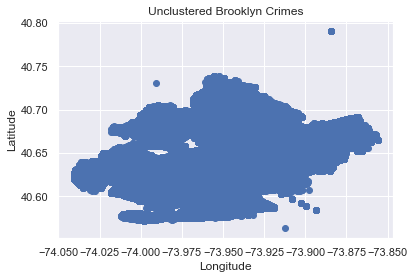

In [79]:
plt.scatter(bk_cluster['Longitude'],bk_cluster['Latitude'])
#plt.xlim(-74.05,-73.80)
#plt.ylim(40.60,40.90)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Unclustered Brooklyn Crimes')
plt.show()

In [93]:
bk_cluster = bk_cluster.dropna()
bk_cluster.isna().sum()
x = bk_cluster.iloc[:,0:3] # 1t for rows and second for columns
kmeans = KMeans(2)
kmeans.fit(x)
identified_clusters_bk = kmeans.fit_predict(x)
identified_clusters_bk

array([1, 0, 1, ..., 1, 1, 1])

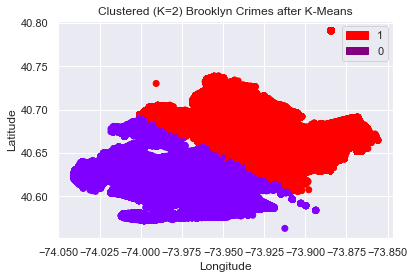

In [95]:
brooklyn_with_clusters = bk_cluster.copy()
brooklyn_with_clusters['Clusters'] = identified_clusters_bk 
plt.scatter(brooklyn_with_clusters['Longitude'],brooklyn_with_clusters['Latitude'],c=brooklyn_with_clusters['Clusters'],cmap='rainbow')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Clustered (K=2) Brooklyn Crimes after K-Means')
red_patch = mpatches.Patch(color='red', label='1')
purple_patch = mpatches.Patch(color='purple', label='0')
#green_patch = mpatches.Patch(color='lightgreen', label='1')
plt.legend(handles=[red_patch, purple_patch])#, green_patch

plt.show()

In [96]:
brooklyn_with_clusters.head(3)

,Longitude,Latitude,Clusters
799032,-73.957114,40.665023,1
799033,-73.964718,40.607011,0
799034,-73.918083,40.697964,1


In [97]:
brooklyn['clusters'] = identified_clusters_bk
#bronx.head(3)
brooklyn = brooklyn.drop(['PATROL_BORO', 'Longitude', 'Latitude','index','borough'], axis=1)
brooklyn = brooklyn.dropna()
print(len(brooklyn))
brooklyn['clusters'].value_counts() ##0 is southwest; 1 is northeast

521622


1    348069
0    173553
Name: clusters, dtype: int64

In [98]:
y_bk = np.array(brooklyn['clusters'])
Xtil_bk = np.array(brooklyn.iloc[:,0:123])
#Xtil_st[0]
(Xt_bk ,Xv_bk ,Yt_bk ,Yv_bk)= train_test_split (Xtil_bk ,y_bk, test_size =0.3 , random_state =0, shuffle = True)

#### Logistic Brooklyn

In [105]:
log_bk = LogisticRegression(penalty='l1', solver='liblinear', C=10.0)
log_bk.fit(Xt_bk, Yt_bk)
Ypred_bk = log_bk.predict(Xv_bk)
print('accuracy: ', log_bk.score(Xv_bk,Yv_bk))

logit_conf_matrix_bk = confusion_matrix(Yv_bk, log_bk.predict(Xv_bk))
print(logit_conf_matrix_bk)

print(classification_report(Yv_bk, Ypred_bk))
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores_log_bk = cross_val_score(log_bk, Xtil_bk, y_bk, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_log_bk))

accuracy:  0.7313514860659351
[[19915 32037]
 [10003 94532]]
              precision    recall  f1-score   support

           0       0.67      0.38      0.49     51952
           1       0.75      0.90      0.82    104535

    accuracy                           0.73    156487
   macro avg       0.71      0.64      0.65    156487
weighted avg       0.72      0.73      0.71    156487

0.7314587970803377


#### LDA Brooklyn

In [99]:
lda_bk = LinearDiscriminantAnalysis()
lda_bk.fit(Xt_bk, Yt_bk)

Ypr_lda_bk = lda_bk.predict(Xv_bk)
print("Accuracy:",metrics.accuracy_score(Yv_bk, Ypr_lda_bk))
print(confusion_matrix(Yv_bk, Ypr_lda_bk))
print(classification_report(Yv_bk, Ypr_lda_bk))
#evaluate model
scores_lda_bk = cross_val_score(lda_bk, Xtil_bk, y_bk, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_lda_bk))

Accuracy: 0.7049147852537272
[[  8766  43186]
 [  2991 101544]]
              precision    recall  f1-score   support

           0       0.75      0.17      0.28     51952
           1       0.70      0.97      0.81    104535

    accuracy                           0.70    156487
   macro avg       0.72      0.57      0.54    156487
weighted avg       0.72      0.70      0.64    156487

0.7038890239391625


#### KNN Regression Brooklyn

In [100]:
bk_n = int(((len(brooklyn))**.5)-1)
print('K: ', bk_n)
knn_bk = KNeighborsClassifier(n_neighbors=bk_n)
knn_bk.fit(Xt_bk, Yt_bk)

#Predict the response for test dataset
Ypr_knn_bk = knn_bk.predict(Xv_bk)
print("Accuracy:",metrics.accuracy_score(Yv_bk, Ypr_knn_bk))
print(confusion_matrix(Yv_bk, Ypr_knn_bk))
print(classification_report(Yv_bk, Ypr_knn_bk))

K:  721
Accuracy: 0.7231463316441621
[[15448 36504]
 [ 6820 97715]]
              precision    recall  f1-score   support

           0       0.69      0.30      0.42     51952
           1       0.73      0.93      0.82    104535

    accuracy                           0.72    156487
   macro avg       0.71      0.62      0.62    156487
weighted avg       0.72      0.72      0.68    156487



In [120]:
##RUN LATER
scores_knn_bk = cross_val_score(knn_bk, Xtil_bk, y_bk, scoring='accuracy', cv=cv, n_jobs=-1)
print('CV accuracy: ', np.mean(scores_knn_bk))

CV accuracy:  0.7242313425428402


# Queens Models

In [106]:
queens = df[df['borough']=='queens']
queens = queens.dropna()
#bronx.head(3)
len(queens)
index_queens = list(range(1, len(queens)+1))
queens['index'] = index_queens
#bronx.head(1)
qn_cluster = queens[['Longitude', 'Latitude']]
qn_cluster.head(3)

,Longitude,Latitude
0,-73.826917,40.762334
1,-73.915508,40.769306
2,-73.900820,40.717372


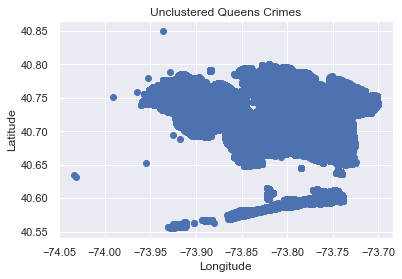

In [107]:
plt.scatter(qn_cluster['Longitude'],qn_cluster['Latitude'])
#plt.xlim(-74.05,-73.80)
#plt.ylim(40.60,40.90)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Unclustered Queens Crimes')
plt.show()

In [108]:
qn_cluster = qn_cluster.dropna()
qn_cluster.isna().sum()
x = qn_cluster.iloc[:,0:3] # 1t for rows and second for columns
kmeans = KMeans(2)
kmeans.fit(x)
identified_clusters_qn = kmeans.fit_predict(x)
identified_clusters_qn

array([1, 1, 1, ..., 1, 0, 1])

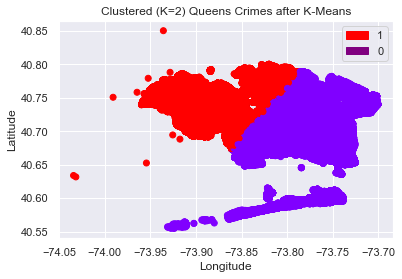

In [109]:
queen_with_clusters = qn_cluster.copy()
queen_with_clusters['Clusters'] = identified_clusters_qn 
plt.scatter(queen_with_clusters['Longitude'],queen_with_clusters['Latitude'],c=queen_with_clusters['Clusters'],cmap='rainbow')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Clustered (K=2) Queens Crimes after K-Means')
red_patch = mpatches.Patch(color='red', label='1')
purple_patch = mpatches.Patch(color='purple', label='0')
#green_patch = mpatches.Patch(color='lightgreen', label='1')
plt.legend(handles=[red_patch, purple_patch])#, green_patch

plt.show()

In [111]:
queen_with_clusters.head(3)

,Longitude,Latitude,Clusters
0,-73.826917,40.762334,1
1,-73.915508,40.769306,1
2,-73.900820,40.717372,1


In [112]:
queens['clusters'] = identified_clusters_qn
#bronx.head(3)
queens = queens.drop(['PATROL_BORO', 'Longitude', 'Latitude','index','borough'], axis=1)
queens = queens.dropna()
print(len(queens))
queens['clusters'].value_counts() ##0 is southwest; 1 is northeast

360467


1    180742
0    179725
Name: clusters, dtype: int64

In [113]:
y_qn = np.array(queens['clusters'])
Xtil_qn = np.array(queens.iloc[:,0:123])
#Xtil_st[0]
(Xt_qn ,Xv_qn ,Yt_qn ,Yv_qn)= train_test_split (Xtil_qn ,y_qn, test_size =0.3 , random_state =0, shuffle = True)

#### Logistic Queens

In [114]:
log_qn = LogisticRegression(penalty='l1', solver='liblinear', C=10.0)
log_qn.fit(Xt_qn, Yt_qn)
Ypred_qn = log_bk.predict(Xv_qn)
print('accuracy: ', log_qn.score(Xv_qn,Yv_qn))

logit_conf_matrix_qn = confusion_matrix(Yv_qn, log_qn.predict(Xv_qn))
print(logit_conf_matrix_qn)

print(classification_report(Yv_qn, Ypred_qn))
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores_log_qn = cross_val_score(log_qn, Xtil_qn, y_qn, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_log_qn))

accuracy:  0.6959340120768256
[[34446 19472]
 [13410 40813]]
              precision    recall  f1-score   support

           0       0.44      0.13      0.20     53918
           1       0.49      0.84      0.62     54223

    accuracy                           0.48    108141
   macro avg       0.47      0.48      0.41    108141
weighted avg       0.47      0.48      0.41    108141

0.6927430230667287


#### LDA Queens

In [115]:
lda_qn = LinearDiscriminantAnalysis()
lda_qn.fit(Xt_qn, Yt_qn)

Ypr_lda_qn = lda_qn.predict(Xv_qn)
print("Accuracy:",metrics.accuracy_score(Yv_qn, Ypr_lda_qn))
print(confusion_matrix(Yv_qn, Ypr_lda_qn))
print(classification_report(Yv_qn, Ypr_lda_qn))
#evaluate model
scores_lda_qn = cross_val_score(lda_qn, Xtil_qn, y_qn, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores_lda_qn))

Accuracy: 0.6871121961143322
[[37519 16399]
 [17437 36786]]
              precision    recall  f1-score   support

           0       0.68      0.70      0.69     53918
           1       0.69      0.68      0.68     54223

    accuracy                           0.69    108141
   macro avg       0.69      0.69      0.69    108141
weighted avg       0.69      0.69      0.69    108141

0.6827559784054756


#### KNN Queens

In [116]:
qn_n = int(((len(queens))**.5)-1)
print('K: ', qn_n)
knn_qn = KNeighborsClassifier(n_neighbors=qn_n)
knn_qn.fit(Xt_qn, Yt_qn)

#Predict the response for test dataset
Ypr_knn_qn = knn_qn.predict(Xv_qn)
print("Accuracy:",metrics.accuracy_score(Yv_qn, Ypr_knn_qn))
print(confusion_matrix(Yv_qn, Ypr_knn_qn))
print(classification_report(Yv_qn, Ypr_knn_qn))

K:  599
Accuracy: 0.6903949473372726
[[33721 20197]
 [13284 40939]]
              precision    recall  f1-score   support

           0       0.72      0.63      0.67     53918
           1       0.67      0.76      0.71     54223

    accuracy                           0.69    108141
   macro avg       0.69      0.69      0.69    108141
weighted avg       0.69      0.69      0.69    108141



In [121]:
##RUN LATER
scores_knn_qn = cross_val_score(knn_qn, Xtil_qn, y_qn, scoring='accuracy', cv=cv, n_jobs=-1)
print('CV accuracy: ', np.mean(scores_knn_qn))

CV accuracy:  0.688190589302373
